# Hydro 4 samples

__Description__: Prepares the shape of the 4 sampled Atlas 14 nested hyetographs

__Input__: 
- Parameters: curve number; the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html));.
        
- The area averaged precipitation frequency data for the specified duration.

- `DataRepository` folder which contains the following:
    - The *Temporal_Distributions* folder, containing [precipitation temporal distribution data](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html) broken down by quartile for the specified volume, region, and duration.

    - The *Temporal_Distribution_Data_Map.json* which contains metadata used to extract the temporal distribution data from its *.csv file.

    - The *Temporal_Quartile_Ranks.xlsx* which contains the percentage of precipitation events whose temporal distributions are represented by those in each quartile. [Source](https://www.nws.noaa.gov/oh/hdsc/currentpf.html). 

    - The *NEH630_Table_10_1.json* which contains information about the spread of possible values around the provided (expected) curve number. [Source](https://www.wcc.nrcs.usda.gov/ftpref/wntsc/H&H/NEHhydrology/ch10.pdf).


__Output__: Samples and weights for hyetographs


---

## A. Load Libraries, Parameters, and Data:

### Libraries:

In [2]:
import sys
sys.path.append('../../core')
import hydromet_conv
from hydromet import*

### Parameters: 

#### Papermill (volume/region/duration dependent):

In [28]:
## NOAA parameters:
duration = 24   # Event duration in hour


## Filenames and paths:
Project_Area = 'Amite_WA2'  # Project area name
Pluvial_Model = 'P01'  # Pluvial model name
BCN = '080702020804'  # Domain/boundary condition name
precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NOAA Data


root_dir = pl.Path(os.getcwd())
inputs_dir = root_dir/'Inputs'
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
datarepository_dir = root_dir.parent.parent/'DataRepository'
bin_dir = root_dir.parent.parent/'bin'


## Options:
display_plots = True
display_print = True

##### Convert all paths to objects:

In [29]:
inputs_dir = pl.Path(inputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
datarepository_dir = pl.Path(datarepository_dir)
bin_dir = pl.Path(bin_dir)
outputs_dir = pl.Path(outputs_dir)

#### Global (project specific):

In [30]:
## Filenames and paths:
Temporal_Distribution_Data_Map = 'Temporal_Distribution_Data_Map.json'
Temporal_Quartile_Ranks = 'Temporal_Quartile_Ranks.xlsx'
CN_Distribution = 'NEH630_Table_10_1.json'
temporal_dir = datarepository_dir/'Temporal_Distributions'
lower_limit = 1


start_time = time.time()

### Data:

#### NOAA Atlas 14 Volume and Region:

In [31]:
if 'Volume' not in locals(): volume, region = get_volume_region(precip_table_dir, display_print = display_print)

NOAA Atlas 14: Volume 9, Region 1


#### Temporal distribution data map:

In [11]:
qmap = get_temporal_map(datarepository_dir, Temporal_Distribution_Data_Map, volume, region, duration, display_print)

{'map': {'q1': [0, 49], 'q2': [52, 101], 'q3': [104, 153], 'q4': [156, 205]}, 'skiprows': 8}


#### Precipitation temporal distribution:

In [12]:
raw_temporals = get_temporals(temporal_dir, volume, region, duration, qmap, display_print)

,90%,80%,70%,60%,50%,40%,30%,20%,10%
hours,,,,,,,,,
0,0,0,0,0,0,0,0,0,0
0.5,0.54,0.95,1.25,1.75,2.20,2.68,5.21,7.91,12.50


None


#### Temporal quartile ranks:

In [13]:
qrank = get_quartile_rank(datarepository_dir, Temporal_Quartile_Ranks, volume, region, duration, display_print)

[0.36, 0.24, 0.23, 0.17]


---

## Show Temporal Distributions:

### Reformat and plot the temporal distribution data:

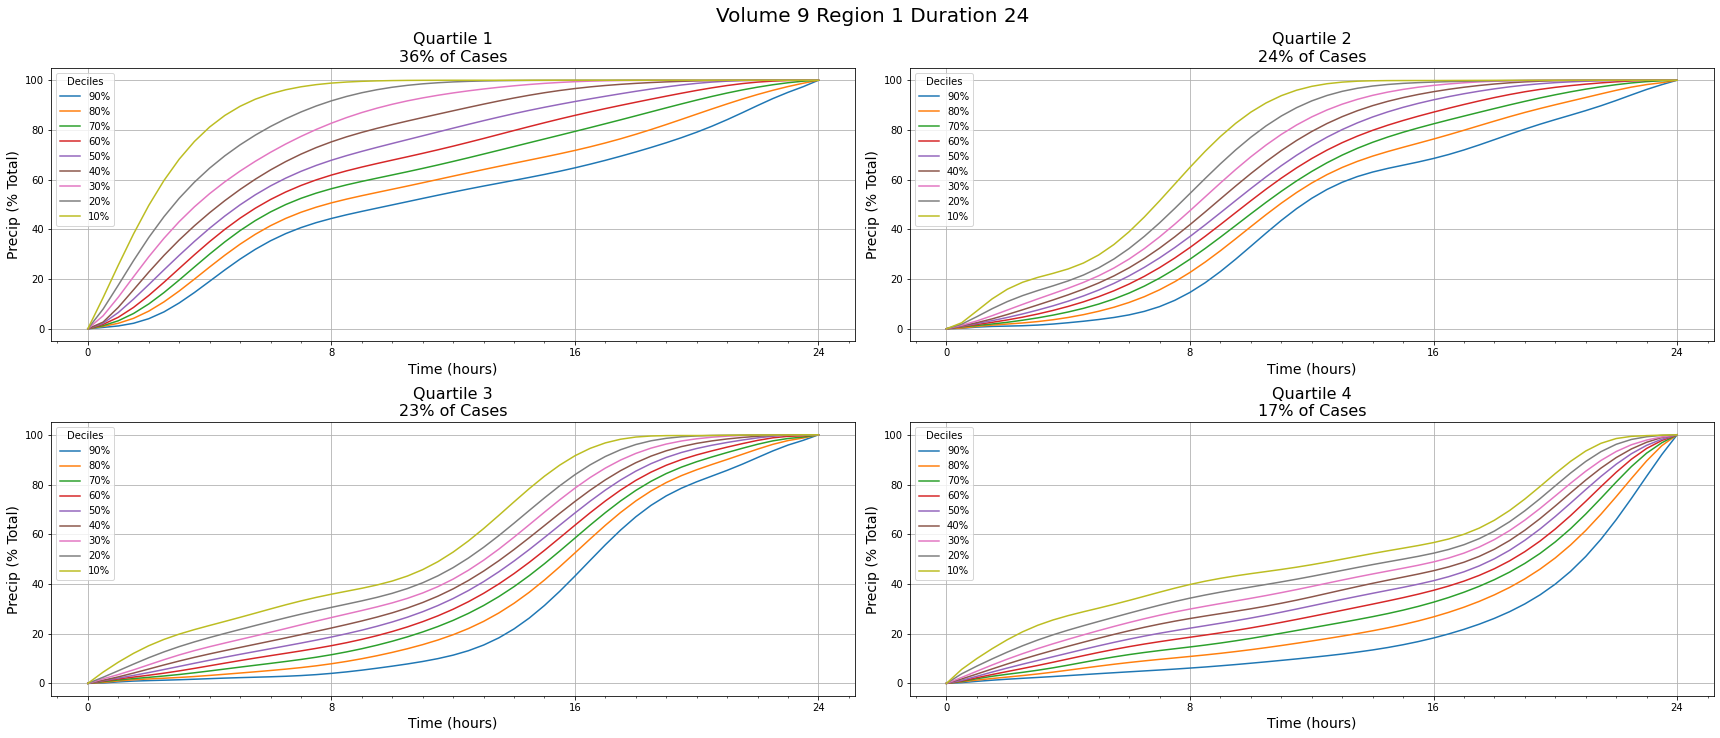

In [14]:
curve_group = get_quartiles(raw_temporals, duration, qrank, qmap, volume, region, plot = display_plots)

## Select Temporal Distributions:

#### Combine deciles and quartiles into 1 dataframe

In [15]:
all_distro = pd.concat([curve_group['q1'], curve_group['q2'],curve_group['q3'],curve_group['q4']], axis=1, keys=['q1','q2','q3','q4'])

#### Set Sampling Plan

In [16]:
#conservative sample from each quartile
samples = ['10%','10%','90%','90%']


[]

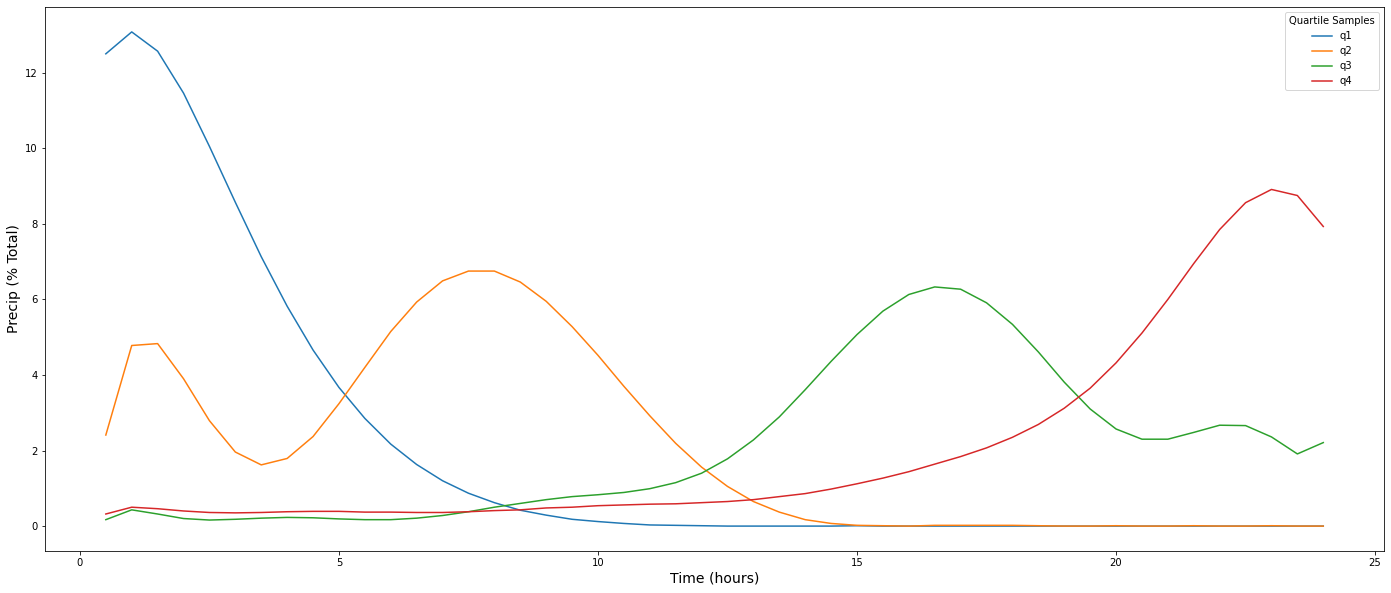

In [17]:
#plot selected samples
select_distro = pd.concat([all_distro['q1'][samples[0]],all_distro['q2'][samples[1]],all_distro['q3'][samples[2]],all_distro['q4'][samples[3]]],axis=1,keys=['q1','q2','q3','q4'])
select_distro_hyetograph = pd.concat([all_distro.diff()['q1'][samples[0]],all_distro.diff()['q2'][samples[1]],all_distro.diff()['q3'][samples[2]],all_distro.diff()['q4'][samples[3]]],axis=1,keys=['q1','q2','q3','q4'])
ax = select_distro_hyetograph.plot(figsize=(24,10))
ax.legend(title='Quartile Samples')
ax.set_xlabel('Time (hours)', fontsize=14)
ax.set_ylabel('Precip (% Total)',fontsize=14)
ax.plot()

#### Check sample weights

In [18]:
#weighted probability of each sample
weights_df = pd.DataFrame(data = qrank,columns = ['weight'])
weights_df.index = ['q1','q2','q3','q4']
weights_df

,weight
q1,0.36
q2,0.24
q3,0.23
q4,0.17


In [19]:
atlas_distro = select_distro.fillna(0.0)/100

In [20]:
atlas_distro.head(2)

,q1,q2,q3,q4
hours,,,,
0.0,0.000,0.0000,0.0000,0.0000
0.5,0.125,0.0241,0.0017,0.0032


---

## Save the Results:

In [21]:
atlas_distro.columns.tolist()

['q1', 'q2', 'q3', 'q4']

In [22]:
#Placeholder for writing to excel file with weights

writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_atlas_temporal_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN))

for i, d in enumerate(atlas_distro.columns.tolist()):
    table = atlas_distro[d]
    table.to_excel(writer, sheet_name = 'atlas_hye_{}'.format(atlas_distro.columns.tolist()[i]))
weights_df.to_excel(writer, sheet_name = 'atlas_hye_weights')

    
writer.save()

---

## END